In [1]:
import numpy as np
from pyspark.sql import SparkSession
import string
from collections import Counter
from PIL import Image
from operator import add
import json
import re
from scipy.sparse import coo_matrix
from pyspark.mllib.clustering import KMeans, KMeansModel

spark = SparkSession.builder.master('local[16]').appName('songs_submit').getOrCreate()

## 3. Song embeddings

### 3.song (c): Get embeddings from GloVe

In [2]:
#get embedding vectors for songs from GloVe
vocab_file   = 'glove/GloVe/song-vocab.txt'
vectors_file = 'glove/GloVe/song-vectors.txt'
with open(vocab_file, 'r') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
with open(vectors_file, 'r') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]
        
vocab  = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

#vectors = {'song_id',[song_vector]}
#vocab = {'song_id',song_id_ix}
#ivocab = {'song_id_ix','song_id'}

In [3]:
#convert glove output to an rdd
g_vec = spark.read.text(vectors_file)
#g_vec.take(1)

In [4]:
#map to (songID,[glove Vec])
#Note, one of the songIDs must be not an integer, because 
g_vec_rdd = g_vec.rdd.map(lambda x: x[0].encode("ascii", "ignore")).map(lambda x: x.split(' ')).\
                                                map(lambda x: (x[0],[float(y) for y in x[1:]]))
#g_vec.take(1)
#g_vec_rdd.take(1)

### 3.song (d): K-means on embeddings

In [5]:
# Load and parse the data
g_vec_to_clust = g_vec_rdd.map(lambda x: np.array(x[1]))
g_vec_songID = g_vec_rdd.map(lambda x: x[0])

#print g_vec_lab.count()
#print g_vec_to_clust.count()

In [6]:
# Build the model (cluster the data)
clusters = KMeans.train(g_vec_to_clust, 5, maxIterations=100, initializationMode="k-means||")

In [7]:
#predict clusters for every vector
g_vec_predictCluster = g_vec_to_clust.map(lambda x: clusters.predict(x))

In [27]:
#collect songIDs and predicted clusters
songID_glove = g_vec_songID.collect()
cluster_glove = g_vec_predictCluster.collect()

In [39]:
#zip into ([cluster,songID])
glove_zipper = zip(cluster_glove,songID_glove)
# print cluster_glove[0:20]
# print songID_glove[0:10]
# print glove_zipper[0:10]

In [44]:
#get {song,tags dict}
song2tag_file = '/project/cmsc25025/playlist/song-to-tags.txt'
song_ids = []
song_tags = []
song_tags_cnt = []
with open(song2tag_file, 'r') as f:
    for x in f.readlines():
        this_id = x.rstrip().split('\t')[0] 
        song_ids.append(this_id)
   
        this_taglist = x.rstrip().split('\t')[1]
        
        if this_taglist is not '#':
            song_tags.append([int(x) for x in this_taglist.split(',')])
            song_tags_cnt.append(Counter([x for x in this_taglist.split(',')]))
        else:
            song_tags.append('#')
            song_tags_cnt.append(Counter({'#':1}))


In [ ]:
#make a dict of ({'songID':tag_Counter()})
song_tag_zipper = dict(zip(song_ids,song_tags_cnt))
#print song_tag_zipper.popitem()
#song_tag_zipper['5988']

In [48]:
#make {'tagID':'genre_string'} dict; read tag2genre hash
tag2genre_file = '/project/cmsc25025/playlist/tag_hash.txt'
tag2genre = []
with open(tag2genre_file,'r') as f:
    for x in f.readlines():
        tag2genre.append([y.lstrip() for y in x.rstrip().split(',')])
tag2genre = dict(tag2genre)
#tag2genre['1']

In [34]:
#For each cluster, print the top 5 most commonly occurring tags and comment on the results.
cluster_cnts = [] #store sums of counters for every cluster
for c in range(5):
    cluster_cnts.append(Counter())

for clust, songID in glove_zipper:
    try:
        cluster_cnts[clust] = cluster_cnts[clust] + song_tag_zipper[songID]
    except KeyError:
        print songID
#cluster_cnts[0]

<unk>


In [38]:
#print top 5 most common genres per cluster
for c in range(len(cluster_cnts)):
    print '\ncluster ', c, ': (\'tag\',\'no. counts of tag\')'
    print [(tag2genre[x[0]],x[1]) for x in cluster_cnts[c].most_common(10) if x[0] is not '#']


cluster  0 : ('tag','no. counts of tag')
[('rock', 2571), ('pop', 2395), ('favorites', 2264), ('male vocalists', 1820), ('love', 1707), ('classic rock', 1555), ('american', 1342), ('awesome', 1299), ('beautiful', 1260)]

cluster  1 : ('tag','no. counts of tag')
[('pop', 113), ('dance', 97), ('hip-hop', 90), ('rnb', 87), ('hip hop', 80), ('love', 74), ('party', 73), ('catchy', 71), ('rap', 69), ('american', 69)]

cluster  2 : ('tag','no. counts of tag')
[('country', 238), ('my favorite', 176), ('great song', 163), ('modern country', 160), ('pop', 110), ('male vocalists', 109), ('love', 103), ('new country', 103), ('favorites', 99), ('beautiful', 91)]

cluster  3 : ('tag','no. counts of tag')
[('rock', 540), ('favorites', 481), ('pop', 432), ('male vocalists', 379), ('alternative', 369), ('american', 365), ('awesome', 361), ('love', 346), ('alternative rock', 328), ('hard rock', 308)]

cluster  4 : ('tag','no. counts of tag')
[('pop', 438), ('favorites', 374), ('love', 365), ('rock', 36

It looks like some of the clusters are readily interpretable, whereas others less so. In general, cluster 0 is much bigger than the others (as judged by number of tag counts). I deliberately plotted the first 10 (not 5) tags to get a bit more intuition about what's in each cluster. 
- Cluster 1 organizes hip-hop/rnb/rap party music
- Cluster 2 organizes country music
- Clusters 0, 3 and 4 seem to all have rock and pop, a lot of about love, by male vocalists and American bands. But I think we can make out some distinctions:
    - Cluster 0 includes tags like 'classic rock' and 'beautiful', suggesting that this cluster collects melodic classic rock tunes
    - Cluster 3 includes tags like 'alternative rock' and 'hard rock', suggesting that these songs might be harder, metal-type rock
    - Cluster 4, on the other hand, has the unique 'pop rock' tag, suggesting that these are more popular rock songs.

### 3 song (e): t-SNE

In [8]:
#make {'songID':'artist'} dictionary
song2artist_file = '/project/cmsc25025/playlist/song_hash.txt'
with open(song2artist_file,'r') as f:
     boo = [x.rstrip().split('\t') for x in f.readlines()]
boo_a,boo_b,boo_c=zip(*boo)
song2artist = dict(zip(boo_a,boo_c))
song2title = dict(zip(boo_a,boo_b))

In [9]:
#W contains the embedding vectors as rows, 
#and words contains the word labels in the same order as the rows of W, 
#the following code will produce an interactive 
#plot of the first 1000 embedding vectors:

tags, W = zip(*g_vec_rdd.filter(lambda x: x[0] != '<unk>' and x[0] != '#').collect())
words = [song2artist[i] for i in tags]
W = np.array(W)
#print tags[0], words[0], W[0]

<IPython.core.display.Javascript object>


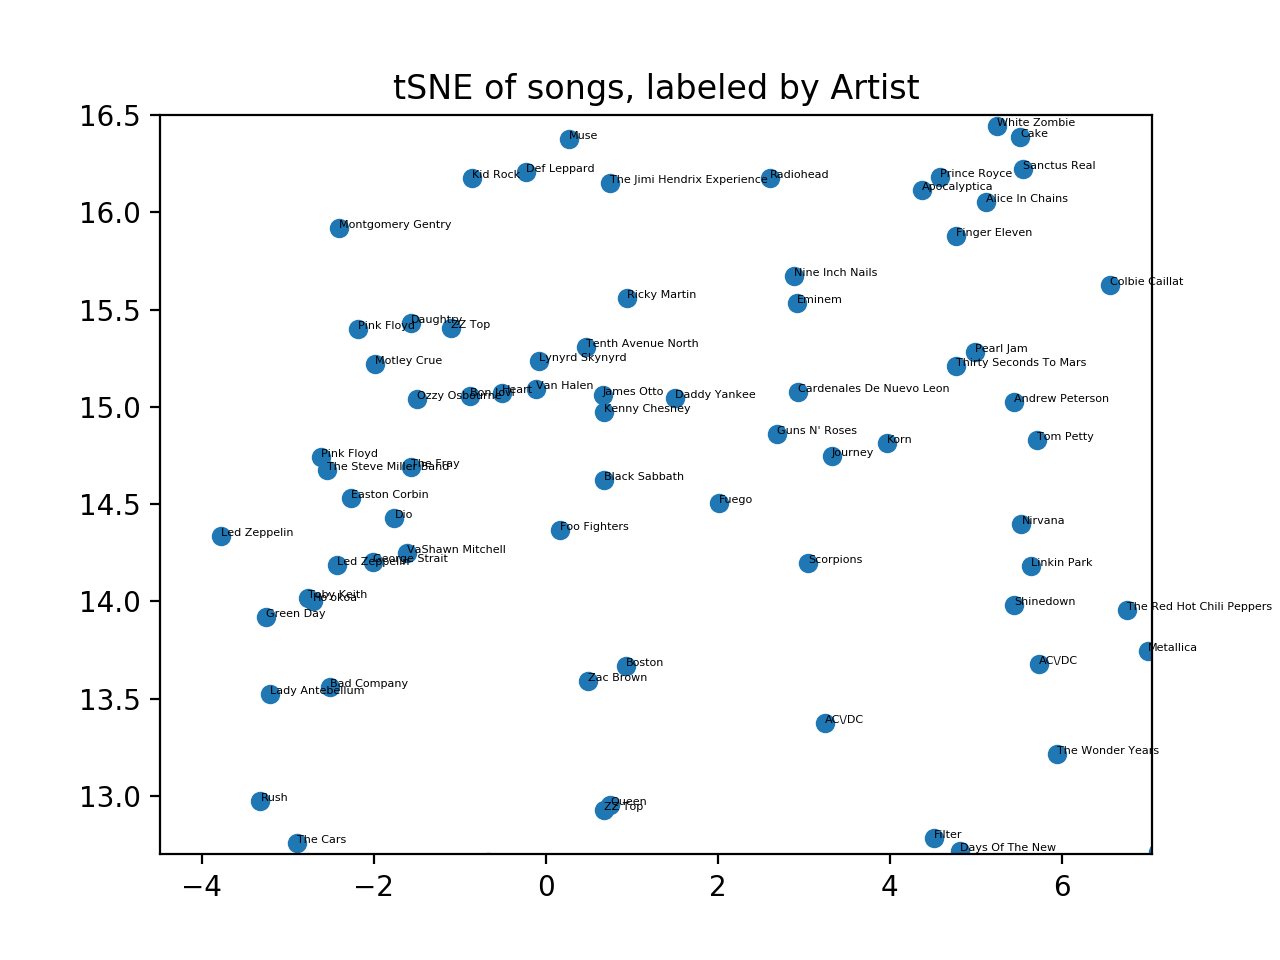

In [10]:
#label songs by artist name
words = [song2artist[i] for i in tags]

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook
#%matplotlib inline

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W[1:1000,:])

plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',fontsize=4)
plt.title('tSNE of songs, labeled by Artist')
plt.show()

(In case the plot zoom disappears during grading, please navigate to x in [-4,8], y in [13,16.5].)

This area of the plot shows a lot of classic rock songs, many on the 'hard rock' side of things, including bands like  AC/DC, Def Leppard, Pearl Jam and ZZ Top (but also general classic rock acts like Tom Petty). Note that these aren't just limited to a single decade, but actually span years from the 60s-70s (ZZ Top) to the 90s (Radiohead, Metallica). However, many of these are all similar in genre. Indeed, my favorite classic rock stations often play lots of these tunes! (Not sure why Colbia Calliat and Eminem are there, but they probably show up on a lot of popular playlists.)

Below, I replotted the same area on the tSNE, but with song names labeling the points instead of the artist names. I'm pretty sure I've heard some of the neighboring tunes on the same playlists on the radio (e.g., Queen's "Bohemian Rhapsody" and ZZ Top's "Sharp Dressed Man", which are very close together near (1,13)). 

<IPython.core.display.Javascript object>


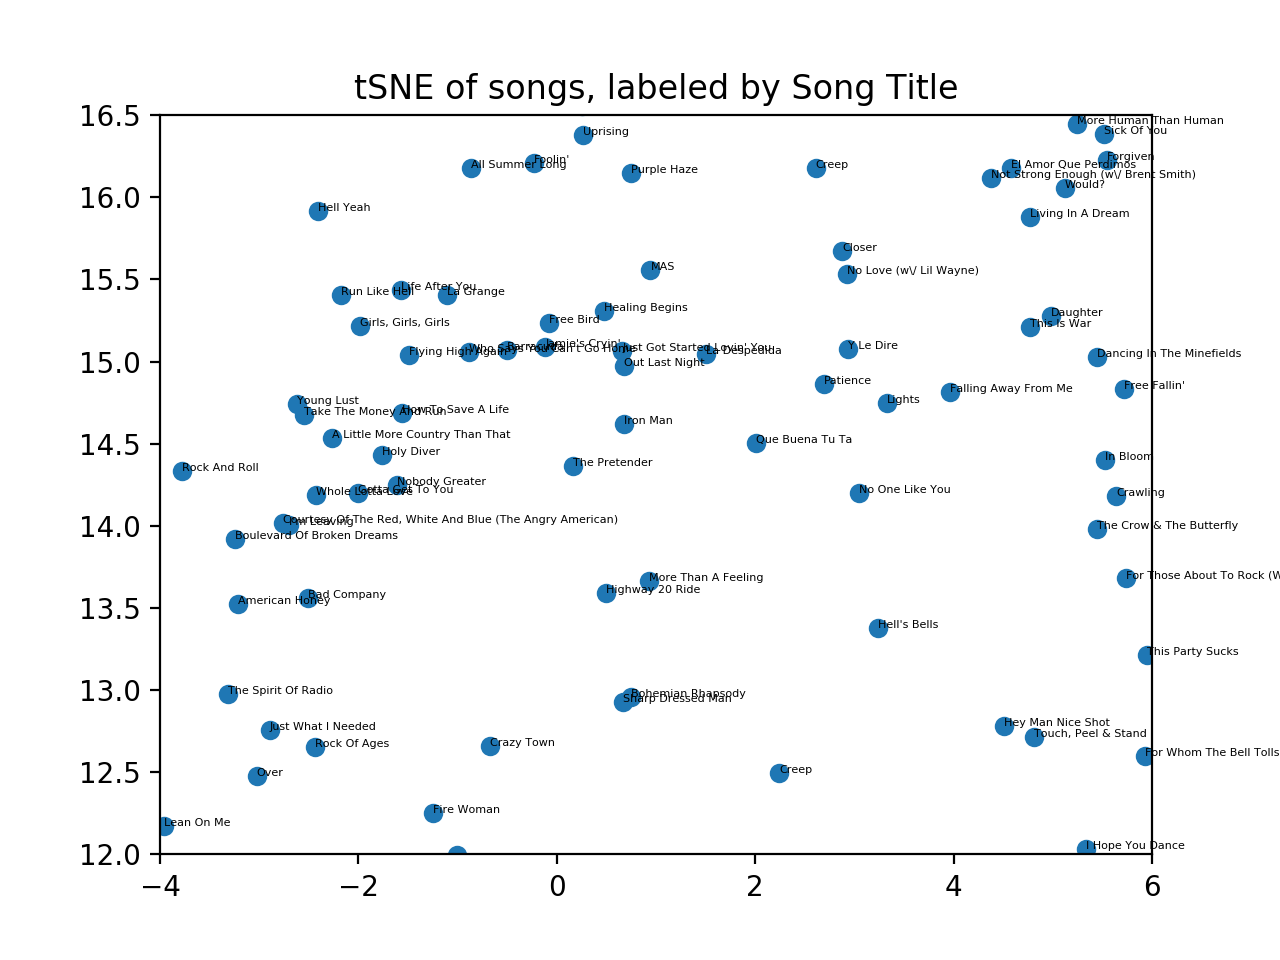

In [11]:
#repeat, but include song titles
words = [song2title[i] for i in tags]

#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt
%matplotlib notebook
#%matplotlib inline

plt.figure()
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',fontsize=4)
plt.title('tSNE of songs, labeled by Song Title')
plt.xlim((-4,6))
plt.ylim((12,16.5))
plt.show()

## 3. Artist Embeddings

### 3 artist (d): closest artists

In [12]:
#convert glove output to an rdd
art_vectors_file = 'glove/GloVe/artist-vectors.txt'
g_art_vec = spark.read.text(art_vectors_file)
#g_art_vec.take(1)

In [13]:
g_art_vec_rdd = g_art_vec.rdd.map(lambda x: x[0].encode("ascii", "ignore")).map(lambda x: x.split(' ')).\
                                                map(lambda x: (x[0],[float(y) for y in x[1:]]))
#g_art_vec_rdd.take(1)

In [14]:
#make {'tagID':'artist_string'} dict; read tag2artist hash
tag2artist_file = '/project/cmsc25025/playlist/artist_hash.txt'
tag2artist = []
with open(tag2artist_file,'r') as f:
    for x in f.readlines():
        tag2artist.append([y.lstrip() for y in x.rstrip().split('\t')])
tag2artist = dict(tag2artist)
artist2tag = dict((v,k) for k,v in tag2artist.iteritems())

print tag2artist['2495']
print artist2tag['The Beatles']

The Beatles
2495


In [15]:
#list of artists whose neighbors you want to find and corresponding IDs
my_artist = ['The Beatles','The Red Hot Chili Peppers', 'Usher', 'Johnny Cash']
my_artist_tag = [artist2tag[i] for i in my_artist]
#print my_artist_tag

In [9]:
#compute euclidean distance between two embedding vectors
def dist2artist(x,y):
    return np.linalg.norm(np.array(x)-np.array(y))

In [10]:
for a in my_artist_tag:
    #get embedding vector for my_artist
    my_emb = g_art_vec_rdd.lookup(a)
    #print '\n', a, my_emb[0]
    
    #compute distances between my_emb and everything in RDD
    temp = g_art_vec_rdd.map(lambda x: (x[0],dist2artist(x[1],my_emb))).takeOrdered(6, lambda x: x[1])
    my_neighbors = [tag2artist[i[0]] for i in temp]
    print '\nClosest artists to ', tag2artist[a], 'are: ', my_neighbors[1:]


Closest artists to  The Beatles are:  ['Creedence Clearwater Revival', 'The Kinks', 'The Electric Light Orchestra', 'America', 'Bachman-Turner Overdrive']

Closest artists to  The Red Hot Chili Peppers are:  ['Stone Temple Pilots', 'Pearl Jam', 'Nirvana', 'Sublime', 'Bush']

Closest artists to  Usher are:  ['B.o.B', 'Far East Movement', 'Flo-Rida', 'B.o.B.', 'Jay Sean']

Closest artists to  Johnny Cash are:  ['Randy Travis', 'Ronnie Milsap', 'Willie Nelson', 'Waylon Jennings', 'Tanya Tucker']


I think these closest artist groupings make a lot of sense. 
- The bands closest to 'The Beatles' are other classic rock acts like CCR, The Kinks, America, etc.
- Artists closest to 'The Red Hot Chili Peppers' are the other more recent rock/alternative rock bands like 'Pearl Jam', 'Sublime' and 'Nirvana'. All of these acts were popular much later than 'The Beatles' (e.g., 90s intead of 60s!)
- Artists closest to 'Usher' are all modern hip-hop acts like 'B.o.B.', 'Flo-Rida', etc. (on Wiki, 'Far East Movement' is even indicated as being associated with 'Flo-Rida'). Note that 'B.o.B.' is spelled in two different ways in the tags and both spellings show up. I guess this is a good sanity check.
- Just for something completely different, I looked up closest artist to an older country performer like 'Johnny Cash.' 'Willie Nelson' is a natural choice.

### 3 artist (e): t-SNE

<IPython.core.display.Javascript object>


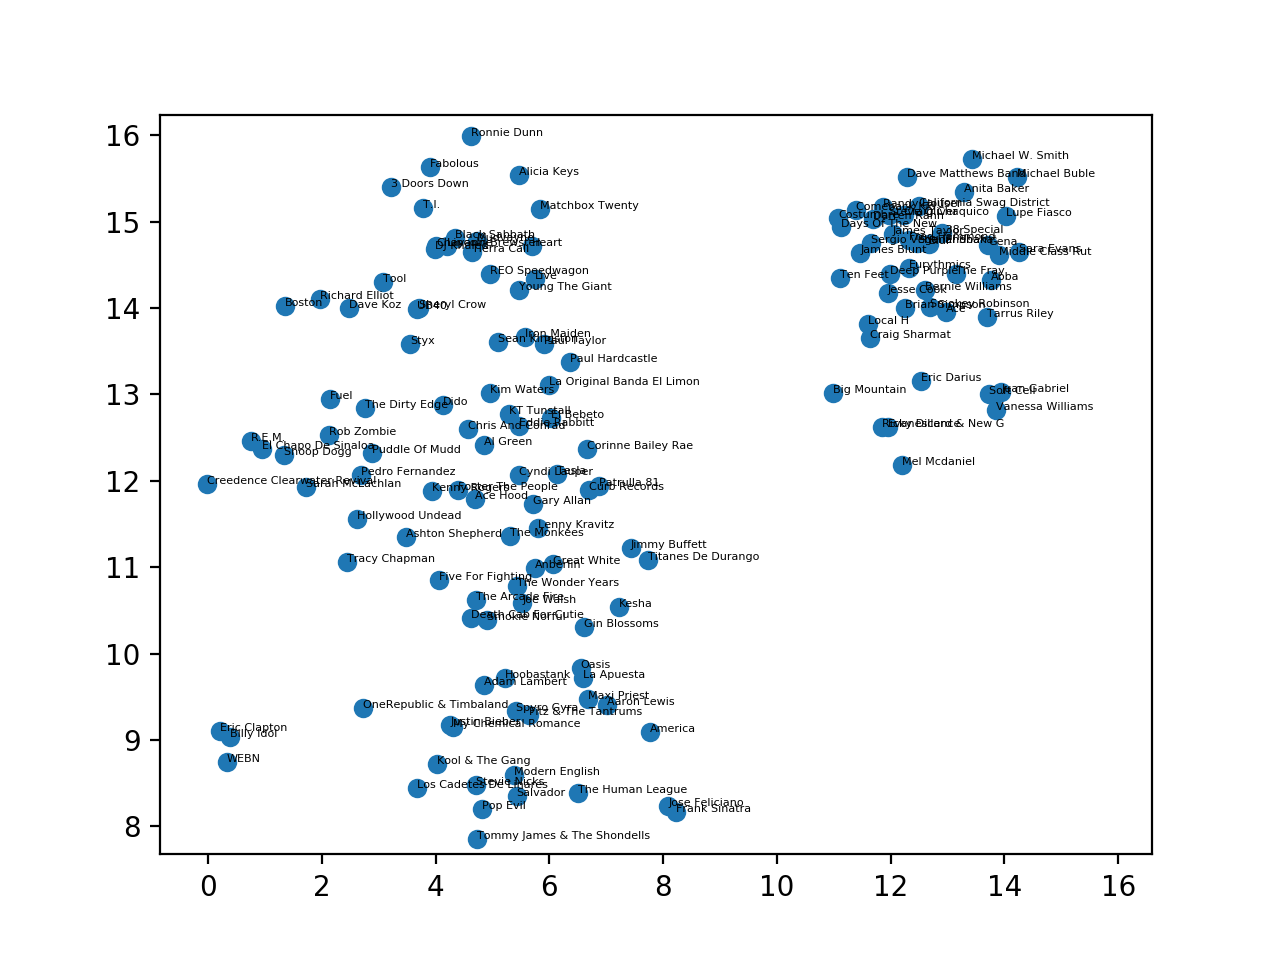

In [16]:
#W contains the embedding vectors as rows, 
#and words contains the word labels in the same order as the rows of W, 
#the following code will produce an interactive 
#plot of the first 1000 embedding vectors:

tags, W = zip(*g_art_vec_rdd.filter(lambda x: x[0] != '<unk>').collect())
words = [tag2artist[i] for i in tags]
W = np.array(W)
#print tags[0], words[0], W[0]

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib notebook

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(W[1:1000,:])

plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',fontsize=4)
plt.show()



In this area of the t-SNE plot we often find pop/rock performers that also fall into a sort of easy listening category:
- Bottom left has Eric Clapton and Billy Idol (both solo performers in a similar genre, so it makes sense that they're so close together) as well as WEBN, apparently a rock radio station. Perhaps they play a lot of these performers on their playlists?
- In the center section, we see classic rock groups like Boston and Styx, along with more modern pop-rock bands like Matchbox 20, Alicia Keys, My Chemical Romance, etc.
- On the top right cluster, there are some different performers, including reggae (Big Mountain, Tarrus Reiley) and jazz (Eric Darius). I'm not familiar with most artists in that region, so it's hard for me to judge how much sense this cluster makes.
- On the very bottom right (8,8.5), Frank Sinatra and Jose Feliciano are both popular male solo performers from the '50s-'60s
